In [79]:
from datetime import timedelta
import math
import random

from pyClarion import (Event, Agent, Priority, Input, Pool, Choice, 
    ChunkStore, BaseLevel, Family, NumDict, Atoms, Atom, Chunk, ks_crawl)

from itertools import product

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm



NUM_CHUNKS = 10
CONSONANTS = "BCDFGHJKLMNPQRSTVWXYZ"
VOWELS = "AEIOU"
NUMBERS = "0123456789"
DELTA_T = timedelta(seconds=3)
random.seed(42)

In [80]:
"""Keyspace Definition"""

class Char(Atoms):
    """Characters for CVC and numbers."""
    A: Atom; B: Atom; C: Atom; D: Atom; E: Atom; F: Atom; G: Atom; H: Atom
    I: Atom; J: Atom; K: Atom; L: Atom; M: Atom; N: Atom; O: Atom; P: Atom
    Q: Atom; R: Atom; S: Atom; T: Atom; U: Atom; V: Atom; W: Atom; X: Atom
    Y: Atom; Z: Atom 
    _0: Atom; _1: Atom; _2: Atom; _3: Atom; _4: Atom; _5: Atom; _6: Atom; 
    _7: Atom; _8: Atom; _9: Atom


class IO(Atoms):
    """IO sort for dimension symbols"""
    cvc1: Atom
    cvc2: Atom
    cvc3: Atom
    num1: Atom
    num2: Atom


class PairedAssoc(Family):
    io: IO
    char: Char

In [81]:
"""Model Construction"""

class Participant(Agent):  
    d: PairedAssoc 
    input: Input
    store: ChunkStore
    blas: BaseLevel
    pool: Pool
    choice: Choice

    def __init__(self, name: str, scale, decay, sd, blw) -> None:
        p = Family()
        e = Family()
        d = PairedAssoc()
        super().__init__(name, p=p, e=e, d=d)
        self.d = d
        with self:
            self.store = ChunkStore("store", d, d, d)
            self.input = Input("input", self.store.chunks)
            self.blas = BaseLevel(
                "blas", p, e, self.store.chunks, sc=scale, de=decay)
            self.pool = Pool("pool", p, self.store.chunks, func=NumDict.sum)
            self.choice = Choice("choice", p, self.store.chunks, sd=sd)
        self.blas.input = self.choice.main
        self.pool["input"] = self.input.main
        self.pool["blas"] = (
            self.blas.main, 
            lambda d: d.bound_min(x=1e-8).log().with_default(c=0.0))
        self.choice.input = self.pool.main
        self.blas.ignore.add(~self.store.chunks.nil)

    def resolve(self, event: Event) -> None:
        if event.source == self.input.send:
            self.blas.update()
        if event.source == self.blas.update:
            self.choice.trigger()

    def start_trial(self, 
        dt: timedelta, 
        priority: Priority = Priority.PROPAGATION
    ) -> None:
        self.system.schedule(self.start_trial, dt=dt, priority=priority)

    def finish_trial(self, 
        dt: timedelta, 
        priority: Priority = Priority.PROPAGATION
    ) -> None:
        self.system.schedule(self.finish_trial, dt=dt, priority=priority)

In [82]:
"""Knowledge Initialization"""

def init_stimuli(d: PairedAssoc, l: list[str]) -> list[Chunk]:
    io, char = d.io, d.char
    return [s ^
        + io.cvc1 ** char[s[0]]
        + io.cvc2 ** char[s[1]]
        + io.cvc3 ** char[s[2]]
        + io.num1 ** char[f"_{s[4]}"]
        + io.num2 ** char[f"_{s[5]}"] 
        for s in l]


In [83]:
def generate_cvc_list(n):
    items = []
    visited = set()
    for _ in range(n):
        c1 = random.choice(CONSONANTS)
        c2 = random.choice(VOWELS)
        c3 = random.choice(CONSONANTS)
        num1 = random.choice(NUMBERS)
        num2 = random.choice(NUMBERS)

        while c1 + c2 + c3 in visited or num1 + num2 in visited:
            c1 = random.choice(CONSONANTS)
            c2 = random.choice(VOWELS)
            c3 = random.choice(CONSONANTS)
            num1 = random.choice(NUMBERS)
            num2 = random.choice(NUMBERS)

        visited.add(c1 + c2 + c3)
        visited.add(num1 + num2)
        items.append(f"{c1}{c2}{c3}_{num1}{num2}")
    return items

In [84]:
chunks_listed = generate_cvc_list(NUM_CHUNKS)

In [85]:
"""Event Processing"""
def simulate(scale, decay, sd, b):
    participant = Participant("participant", scale, decay, sd, b)
    stimuli = init_stimuli(participant.d, chunks_listed)
    indices = list(range(len(stimuli))) * 2 
    random.shuffle(indices)
    presentations = {}
    trial = 0
    results = {
        "trial": [],
        "stim": [],
        "time": [],
        "delta": [],
        "response": [],
        "correct": [],
        "strength": [],
        "rt": [],
        "decay": [],
        "scale": []
    }
    participant.start_trial(timedelta())
    while participant.system.queue:
        event = participant.system.advance()
        # print(event.describe())
        if event.source == participant.start_trial:
            i = indices[trial]
            stimulus = stimuli[i]
            if i not in presentations:
                participant.store.compile(stimulus)
            else:
                participant.input.send({stimulus: 1, participant.store.chunks.nil: 1.0})
            participant.finish_trial(timedelta(seconds=3))
        if event.source == participant.finish_trial:
            i = indices[trial]
            if i in presentations:
                target = stimuli[i]
                time = participant.system.clock.time / timedelta(seconds=1)
                response_key = participant.choice.poll()[~participant.store.chunks]
                response_chunk = ks_crawl(participant.system.root, response_key)
                results["trial"].append(trial)
                results["stim"].append(target._name_)
                results["time"].append(time)
                results["delta"].append((trial - presentations[i]) * 3)
                results["response"].append(response_chunk._name_)
                results["correct"].append(response_chunk == target)
                results["strength"].append(participant.choice.sample[0][response_key])
                results["rt"].append(math.exp(-participant.choice.sample[0][response_key]))
                results["decay"].append(decay)
                results["scale"].append(scale)
            else:
                presentations[i] = trial
            if trial < 2 * len(stimuli) - 1:
                participant.start_trial(timedelta(seconds=3))
                trial += 1
    return results

In [86]:
scales = [2000, 10000]
decays = [0.4, 0.6] * 1000
sds = [2 ** -0.5]
blw = [0.1]

In [87]:
results = []

random.seed(42)
for scale, decay, sd, b in product(scales, decays, sds, blw):
    results.append(simulate(scale, decay, sd, b))
results_df = pd.concat([pd.DataFrame(r) for r in results])
results_df["scale"] = results_df["scale"] / 1000

In [ ]:
# Group by relevant columns and calculate the mean of 'correct'
mean_correct = results_df.groupby(["delta", "decay", "scale"])["correct"].transform("mean")

# Filter out rows where the mean of 'correct' is 0
results_df = results_df[mean_correct != 0]

[10.]


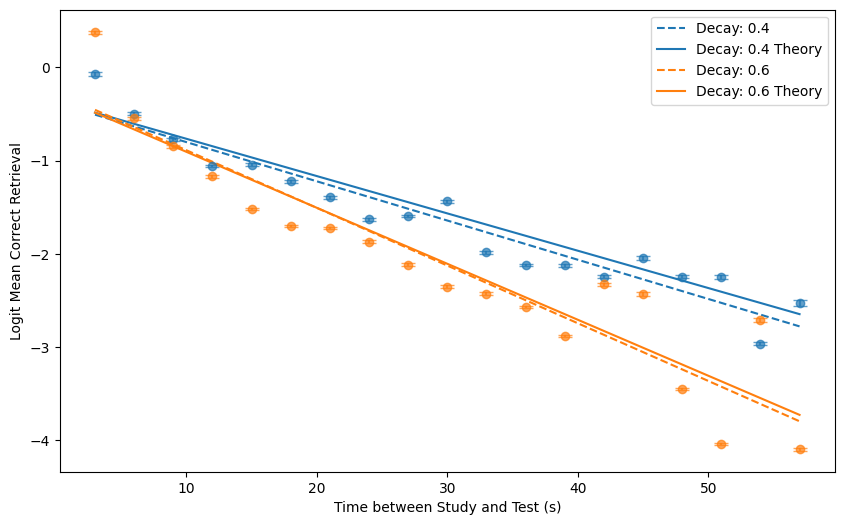

[2.]


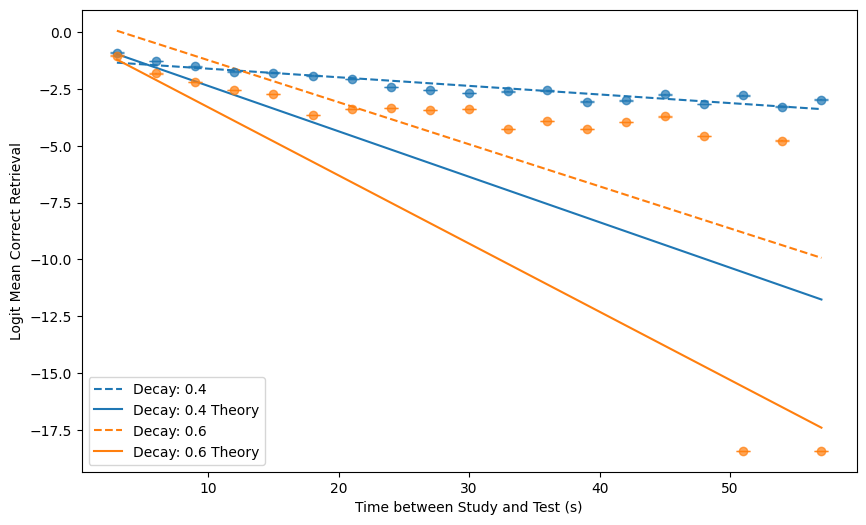

In [140]:
""" Plot Mean Correct Retrieval vs Delta (Interval between study and test). """
df_2000 = results_df.loc[results_df["scale"].eq(2)]
df_10000 = results_df.loc[results_df["scale"].eq(10)]


def mean_delta_plot(df):
    plt.figure(figsize=(10, 6))
    
    scale = df["scale"].unique()
    print(scale)

    delta_data = df.groupby(["delta", "decay"])["correct"].agg(
        ["mean", "std", "sem"]).reset_index()
    # delta_data = delta_data.loc[delta_data["delta"].le(9)]
    # mean_correct = delta_data.groupby(["delta", "decay"])["mean"].transform("mean")
    # delta_data = delta_data[mean_correct != 0]

    delta_data["mean"] = delta_data["mean"].apply(lambda p: math.log(p / (1 - p + 1e-8) + 1e-8))
    cmap = {v: i for i, v in enumerate(delta_data["decay"].unique())}
    grp = delta_data.groupby("decay")

    for decay, grpd in grp:
        plt.errorbar(grpd["delta"], grpd["mean"], yerr=grpd["sem"],
                     color=f"C{cmap[decay]}", fmt='o', alpha=.7, capsize=5)
        # m, b = np.polyfit(grpd["delta"], grpd["mean"], 1)
        # plt.plot(grpd["delta"], [m*x + b for x in grpd["delta"]],
        #          color=f"C{cmap[decay]}", label=f"Decay: {decay}")
        x = grpd["delta"]
        y = grpd["mean"]

        degree = 1
        coefficients = np.polyfit(x, y, degree)
        polynomial = np.poly1d(coefficients)

        x_curve = np.linspace(x.min(), x.max(), 100)
        y_curve = polynomial(x_curve)

        # print(x_curve)

        y_theory = -decay / (scale) * x_curve + decay * np.log(decay)

        plt.plot(x_curve, y_curve,
                 color=f"C{cmap[decay]}", linestyle='dashed', label=f"Decay: {decay}")
        plt.plot(x_curve, y_theory,
                 color=f"C{cmap[decay]}", linestyle='solid', label=f"Decay: {decay} Theory")

    # plt.title("Mean Correct Retrieval vs Delta (Interval between study and test)")
    plt.xlabel("Time between Study and Test (s)")
    plt.ylabel("Logit Mean Correct Retrieval")
    plt.legend()
    plt.show()

# print(results_df)
mean_delta_plot(df_10000)
mean_delta_plot(df_2000)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
df = results_df.copy()

df["delta_decay"] = df["delta"] * df["decay"]
df["delta_scale"] = df["delta"] * df["scale"]

Y = df["correct"]
X = df[["delta", "decay", "scale", "delta_decay", "delta_scale"]]


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = linear_model.LinearRegression()

model.fit(X, Y)

print("Coefficients: ", model.coef_)
print("Intercept: ", model.intercept_)
# Graph of the model



Coefficients:  [-0.01556219  0.00029605]
Intercept:  0.28990912689658754
